In [17]:
# 导包
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd, nd

## 获取和读取数据

In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## 初始化模型参数

In [3]:
# 输入向量的长度是28 × 28 = 784
num_inputs = 784
num_ouputs = 10

# W规模: 784 * 10  b规模: 10 × 1
W = nd.random.normal(scale=0.1, shape=(num_inputs, num_ouputs))
b = nd.zeros(num_ouputs)

# 给模型参数附上梯度
W.attach_grad()
b.attach_grad()

## 实现softmax运算

In [4]:
# 对行和列相加，并保留该维度(keepdims=True)
X = nd.array([
                [1, 2, 3],
                [4, 5, 6]
            ])
X.sum(axis=0, keepdims=True), X.sum(axis=1, keepdims=True)

(
 [[5. 7. 9.]]
 <NDArray 1x3 @cpu(0)>,
 
 [[ 6.]
  [15.]]
 <NDArray 2x1 @cpu(0)>)

In [5]:
def softmax(X):
    X_exp = X.exp()
    partition = X_exp.sum(axis=1, keepdims=True)
    return X_exp / partition # 这里应用了广播机制

In [6]:
X = nd.random.normal(shape=(2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(axis=1)

(
 [[0.21324193 0.33961776 0.1239742  0.27106097 0.05210521]
  [0.11462264 0.3461234  0.19401033 0.29583326 0.04941036]]
 <NDArray 2x5 @cpu(0)>,
 
 [1.0000001 1.       ]
 <NDArray 2 @cpu(0)>)

## 定义模型

In [7]:
# reshape((-1,xxx)) 这样就会把原来的矩阵变成一维的向量
def net(X):
    return softmax(nd.dot(X.reshape((-1, num_inputs)), W) + b)

## 定义损失函数

In [8]:
# 为了得到标签的预测概率，我们可以使用pick函数
y_hat = nd.array(
                    [
                        [0.1, 0.3, 0.6],
                        [0.3, 0.2, 0.5]
                    ]
                )
y = nd.array([0,2], dtype='int32')
nd.pick(y_hat, y)


[0.1 0.5]
<NDArray 2 @cpu(0)>

In [9]:
# 实现交叉熵损失函数.
def cross_entropy(y_hat, y):
    return -nd.pick(y_hat, y).log()

## 计算分类准确率

In [10]:
#y_hat.argmax(axis=1) 返回y_hat中每行最大元素的索引
def accuracy(y_hat, y):
    return (y_hat.argmax(axis=1) == y.astype('float32')).mean().asscalar()

In [11]:
accuracy(y_hat,y)

0.5

In [12]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = 0.0, 0
    for X, y in data_iter:
        y = y.astype('float32')
        acc_sum += (net(X).argmax(axis=1) == y).sum().asscalar()
        n += y.size
    return acc_sum / n

In [13]:
evaluate_accuracy(test_iter, net)

0.0925

## 训练模型

In [14]:
num_epochs , lr = 5, 0.1

def train_ch3(net, train_iter, test_iter,
              loss, num_epochs, batch_size,
              params=None, lr=None, trainer=None
             ):
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            with autograd.record():
                y_hat = net(X)
                l = loss(y_hat, y).sum()
            l.backward()
            if trainer is None:
                d2l.sgd(params, lr, batch_size)
            else:
                trainer.step(batch_size)
            y = y.astype('float32')
            train_l_sum += l.asscalar()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().asscalar()
            n += y.size
        test_acc = evaluate_accuracy(test_iter, net)
        print("epoch {},loss {},train acc {},test acc {}".format(epoch + 1, train_l_sum / n, train_acc_sum / n, test_acc))

train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, batch_size, [W,b], lr)
    

epoch 1,loss 0.8265340817769369,train acc 0.7227833333333333,test acc 0.7932
epoch 2,loss 0.5884177006403605,train acc 0.8034166666666667,test acc 0.8171
epoch 3,loss 0.5412562723795573,train acc 0.81735,test acc 0.8236
epoch 4,loss 0.5142631753285726,train acc 0.8262833333333334,test acc 0.8333
epoch 5,loss 0.4992991975148519,train acc 0.8299666666666666,test acc 0.8361


## 预测

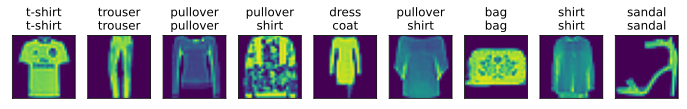

In [19]:
for X, y in test_iter:
    break

true_labels = d2l.get_fashion_mnist_labels(y.asnumpy())
pred_labels = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1).asnumpy())
title = [true + '\n' + pred for true, pred in zip(true_labels,pred_labels)]

d2l.show_fashion_mnist(X[0:9], title[0:9])